<a href="https://colab.research.google.com/github/alphy1/stds-mrl98/blob/main/STDS_Alfiya_Mussabekova_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Techniques for Data Science and Robotics
## Assignment 1
### Alfiya Mussabekova, DS01

To implement MRL98 algorithm, I used paper[1] that presents three different policies for `collapse` operation. My implementation uses the new policy presented in the paper. 

MRL98 has five main functions:
1. `_new` takes as arguments index of the empty buffer, `[start, end)` range from the dataset to put in the empty buffer, and the level of the new buffer. It populates empty buffer with the values from `dataset[start:end]`, assigns it weight $1$ and given level. If the number of elements is less than `k` then it adds `+inf` and `-inf` values until buffer is full.

2. `_collapse` takes as arguments index of the buffer from which collapse will start, and the level of the new collapsed buffer. The function collapses input buffers and puts the result into `start` buffer. 

  For my implementation, buffers with lower indexes will always have level greater or equal than buffers with higher indexes. For example, level list can look like this `[3 2 2 1 0 0 0]`. In this case, collapse will happen to the last three buffers and updated level list will look like this `[3 2 2 1 1 0 0]`. Therefore, we need only the index from where to start collapsing since by policy of the new algorithm only buffers with the smallest level can be collapsed.

3. `_output` is called only once when data sequence is finished. The function sorts elements inside all buffers and computes sum of their weights.

4. `mrl98` - the algorithm itself that calls `_new` and `_collapse` while reading the dataset depending on the collapse policy and calls `_output` when dataset is finished.

5. `find_quantiles` takes as an argument list of quantiles to find, sorts it, and computes each quantile value. Just like in collapse operation, it goes through all buffers in parallel using `cursors` to find value that should be on the quantile positions. It does not use any additional memory for merging buffers. 

References:
1. http://www.cs.umd.edu/~samir/498/manku.pdf

In [ ]:
import sys

class MRL98:
  def __init__(self, N, b, k, dataset):
    self.N = N    # number of elements in dataset
    self.b = b    # number of buffers
    self.k = k    # size of one buffer
    self.beta = 0 # how many inf values added to dataset
    self.buffers = [[] for i in range(b)] # populate empty buffers
    self.l = [0 for i in range(b)]        # in the begging all buffers are at level 0
    self.w = [0 for i in range(b)]        # empty buffers have weight 0
    self.dataset = dataset                # input sequence
    self.all_w = 0                        # sum of all buffers weights, computed once during output operation
    # lists to maintain cursors and new collapsed buffer at each collapse operation
    self.cursors = []
    self.collapsed = []
  
  # compute size of all lists
  def size(self):
    return sys.getsizeof(self.buffers) + sys.getsizeof(self.l) + sys.getsizeof(self.w) + sys.getsizeof(self.cursors) + sys.getsizeof(self.collapsed) 

  def _new(self, empty_buf, start, end, level):
    self.buffers[empty_buf] = self.dataset[start:end]
    self.l[empty_buf] = level
    self.w[empty_buf] = 1
    while len(self.buffers[empty_buf]) < self.k - 1:
      self.buffers[empty_buf].append(float('inf'))
      self.buffers[empty_buf].append(float('-inf'))
      self.beta += 2

  def _collapse(self, start, level):
    # sort all input buffers
    all_w = 0
    for i in range(start, self.b):
      self.buffers[i].sort()
      all_w += self.w[i]
  
    # merge buffers according to their weights
    self.collapsed = []
    offset = (all_w + all_w % 2) // 2
    current_position = 0
    self.cursors = [0] * self.b      # cursors for each buffer
    while len(self.collapsed) < self.k:
      min_id = start
      min_val = float('inf')
      for i in range(start, self.b):
        if self.cursors[i] >= self.k:
          continue
        if self.buffers[i][self.cursors[i]] < min_val:
          min_id = i
          min_val = self.buffers[min_id][self.cursors[min_id]]
        
      if current_position + self.w[min_id] >= offset:
        self.collapsed.append(self.buffers[min_id][self.cursors[min_id]])
        offset += all_w

      self.cursors[min_id] += 1
      current_position += self.w[min_id]
    
    self.buffers[start] = self.collapsed.copy()
    self.w[start] = all_w
    self.l[start] = level

    for i in range(start + 1, self.b):
      self.buffers[i] = [] 
      self.w[i] = 0
      self.l[i] = 0

  def _output(self):
    # sort all buffers
    self.all_w = 0
    self.beta = (self.beta + self.N) / self.N
    for i in range(self.b):
      self.buffers[i].sort()
      self.all_w += self.w[i]

  def find_quantile(self, quantiles):
    vals = []         # computed quantiles
    q = 0             # current quantile to find
    current_position = 0
    self.cursors = [0] * self.b      # cursors for each buffer
    quantile = (2 * quantiles[q] + self.beta - 1) / 2 * self.beta
    find_pos = self.all_w * self.k * quantile
    while q < len(quantiles):
      # find minimum in all bufers
      min_id = 0
      min_val = float('inf')
      for i in range(self.b):
        if self.cursors[i] >= len(self.buffers[i]):
          continue
        if self.buffers[i][self.cursors[i]] < min_val:
          min_id = i
          min_val = self.buffers[min_id][self.cursors[min_id]]
      
      current_position += self.w[min_id]
      self.cursors[min_id] += 1
      while current_position >= find_pos:
        vals.append(min_val)
        q += 1
        if q >= len(quantiles):
          break
        quantile = (2 * quantiles[q] + self.beta - 1) / 2 * self.beta
        find_pos = self.all_w * self.k * quantile
    return vals

  def mrl98(self):
    smallest_level = 0      # the smallest among the levels of currently full buffers
    empty_buffers = self.b  # number of empty buffers
    next_buf = 0            # id of the next empty buffer
    i = 0
    while i < len(self.dataset):
      end = min(i + self.k, len(self.dataset))
      if empty_buffers > 1:
        self._new(next_buf, i, end, 0)
        smallest_level = 0
        empty_buffers -= 1
        next_buf += 1
        i = end
      elif empty_buffers == 1:
        self._new(next_buf, i, end, smallest_level)
        empty_buffers -= 1
        i = end
      else:
        start_collapse = 0
        for j in range(self.b):
          if self.l[j] == smallest_level:
            start_collapse = j
            break
        self._collapse(start_collapse, smallest_level+1)
        smallest_level += 1
        empty_buffers = self.b - start_collapse - 1
        next_buf = start_collapse + 1
    
    self._output()

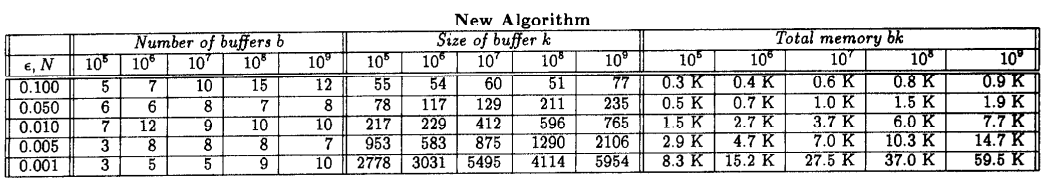

In [ ]:
# dictionary from (N, e) to (b, k)
bk_values = {(10**5, 0.1): (5, 55),
             (10**5, 0.05): (6, 78),
             (10**5, 0.01): (7, 217),
             (10**5, 0.005): (3, 953),
             (10**5, 0.001): (3, 2778),
             
             (10**6, 0.1): (7, 54),
             (10**6, 0.05): (6, 117),
             (10**6, 0.01): (12, 229),
             (10**6, 0.005): (8, 583),
             (10**6, 0.001): (5, 3031),

             (10**7, 0.1): (10, 60),
             (10**7, 0.05): (8, 129),
             (10**7, 0.01): (9, 412),
             (10**7, 0.005): (8, 875),
             (10**7, 0.001): (5, 5495),
             
             (10**8, 0.1): (15, 51),
             (10**8, 0.05): (7, 211),
             (10**8, 0.01): (10, 596),
             (10**8, 0.005): (8, 1290),
             (10**8, 0.001): (9, 4114),

            #  (10**9, 0.1): (12, 77),
            #  (10**9, 0.05): (8, 235),
            #  (10**9, 0.01): (10, 765),
            #  (10**9, 0.005): (7, 2106),
            #  (10**9, 0.001): (10, 5954),
             }

### Test algorithm

1. depending on the dataset size and error value, take `b` and `k` values from the created dictionary
2. populate random sequence
3. run the MRL98 algorithm and measure execution time
4. calculate memory usage 
5. compute 20 different quantiles using mrl algorithm
6. find real quantiles 
7. plot the difference between them

The graphs show that with smaller error the difference between quantiles computed by MRL98 and real ones are smaller and less often. For example, with error = $0.1$ the difference is up to $20$ and just a few values match while with error = $0.001$ the difference is maximum $1$ and most of the values match exactly. 

Quantiles: [0.1        0.14684211 0.19368421 0.24052632 0.28736842 0.33421053
 0.38105263 0.42789474 0.47473684 0.52157895 0.56842105 0.61526316
 0.66210526 0.70894737 0.75578947 0.80263158 0.84947368 0.89631579
 0.94315789 0.99      ]
MRL98 for N=100000 and error=0.1 with b=5 and k=55
Time consumption: 13.098s. Memory usage: 1.031KB


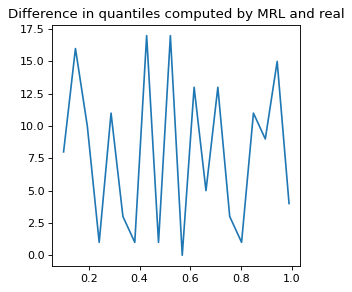

MRL98 for N=100000 and error=0.05 with b=6 and k=78
Time consumption: 0.396s. Memory usage: 1.273KB


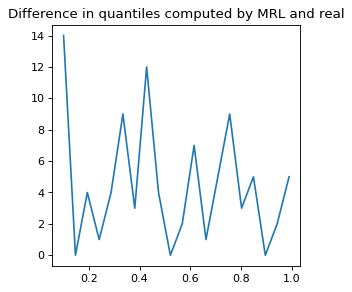

MRL98 for N=100000 and error=0.01 with b=7 and k=217
Time consumption: 0.379s. Memory usage: 2.414KB


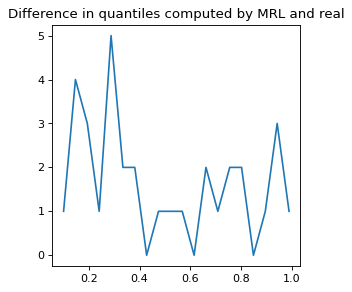

MRL98 for N=100000 and error=0.005 with b=3 and k=953
Time consumption: 0.407s. Memory usage: 8.203KB


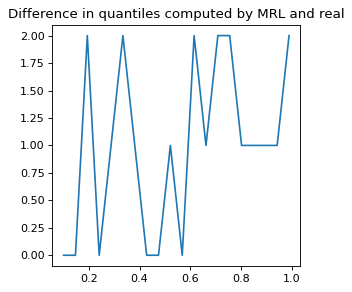

MRL98 for N=100000 and error=0.001 with b=3 and k=2778
Time consumption: 0.381s. Memory usage: 23.578KB


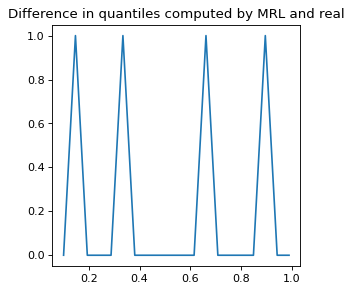

MRL98 for N=1000000 and error=0.1 with b=7 and k=54
Time consumption: 3.842s. Memory usage: 1.047KB


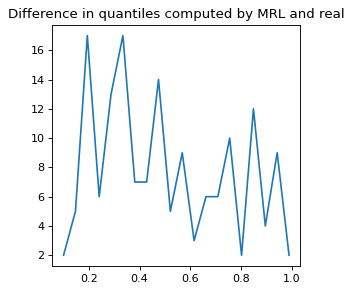

MRL98 for N=1000000 and error=0.05 with b=6 and k=117
Time consumption: 6.191s. Memory usage: 1.570KB


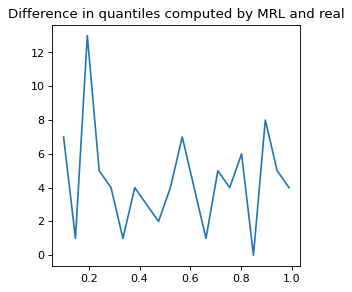

MRL98 for N=1000000 and error=0.01 with b=12 and k=229
Time consumption: 4.118s. Memory usage: 2.641KB


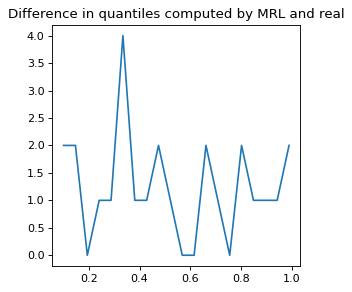

MRL98 for N=1000000 and error=0.005 with b=8 and k=583
Time consumption: 3.894s. Memory usage: 5.273KB


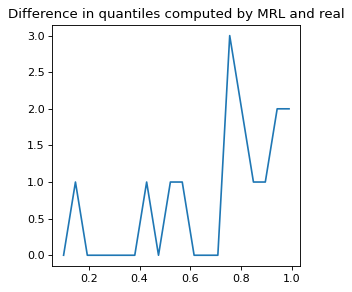

MRL98 for N=1000000 and error=0.001 with b=5 and k=3031
Time consumption: 3.946s. Memory usage: 26.625KB


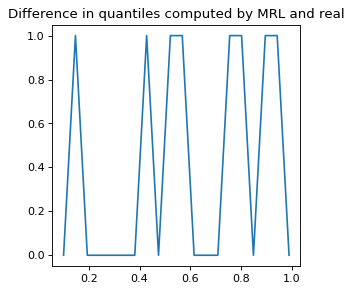

MRL98 for N=10000000 and error=0.1 with b=10 and k=60
Time consumption: 38.196s. Memory usage: 1.367KB


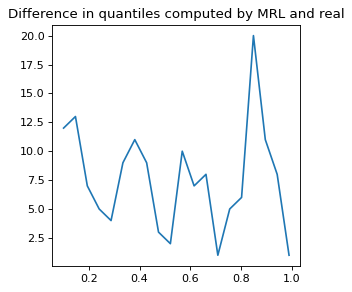

MRL98 for N=10000000 and error=0.05 with b=8 and k=129
Time consumption: 38.921s. Memory usage: 1.758KB


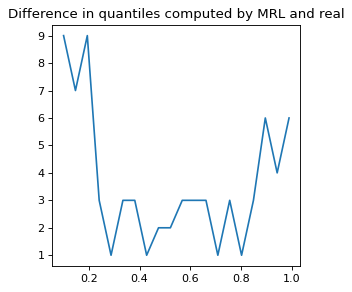

MRL98 for N=10000000 and error=0.01 with b=9 and k=412
Time consumption: 39.246s. Memory usage: 4.406KB


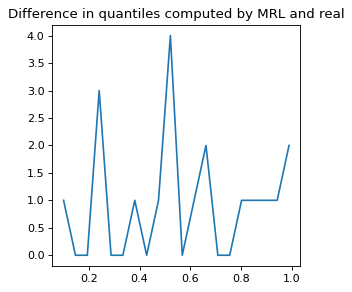

MRL98 for N=10000000 and error=0.005 with b=8 and k=875
Time consumption: 40.314s. Memory usage: 8.336KB


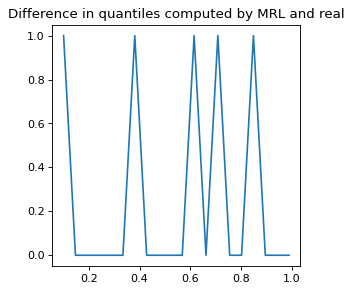

MRL98 for N=10000000 and error=0.001 with b=5 and k=5495
Time consumption: 42.305s. Memory usage: 47.844KB


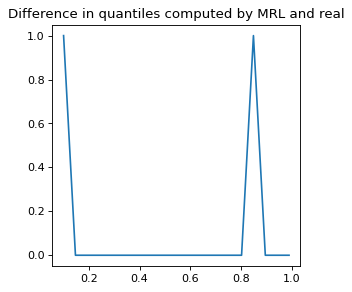

MRL98 for N=100000000 and error=0.1 with b=15 and k=51
Time consumption: 389.364s. Memory usage: 1.297KB


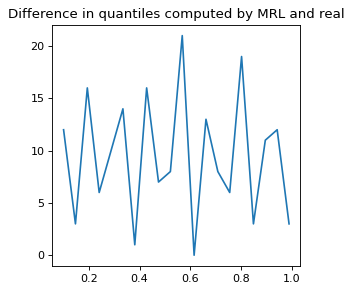

MRL98 for N=100000000 and error=0.05 with b=7 and k=211
Time consumption: 404.563s. Memory usage: 2.414KB


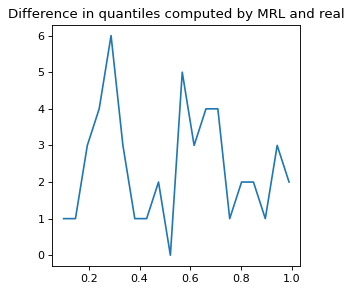

MRL98 for N=100000000 and error=0.01 with b=10 and k=596
Time consumption: 395.653s. Memory usage: 5.477KB


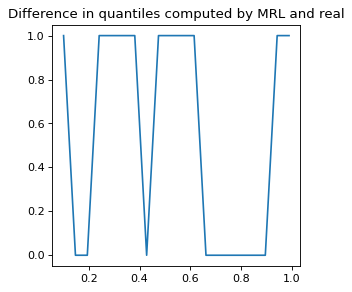

MRL98 for N=100000000 and error=0.005 with b=8 and k=1290
Time consumption: 406.685s. Memory usage: 11.789KB


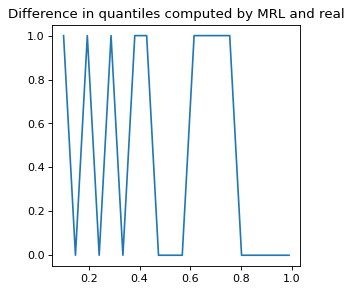

MRL98 for N=100000000 and error=0.001 with b=9 and k=4114
Time consumption: 408.499s. Memory usage: 33.867KB


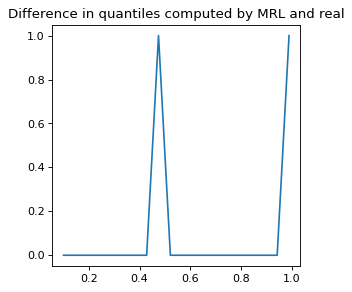

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import random
import time

maxN = 10**3
quantiles = np.linspace(0.1, 0.99, 20)
print("Quantiles:", quantiles)
mems = []
times = []
for (N, e), (b, k) in bk_values.items():
  print(f"MRL98 for N={N} and error={e} with b={b} and k={k}")
  # create random dataset
  dataset = [random.randint(-maxN, maxN) for _ in range(N)]
  mrl = MRL98(N, b, k, dataset)
  # run algorithm and measure time
  start_time = time.time()
  mrl.mrl98()
  times.append(time.time()-start_time)
  # calculate occupied memory
  mems.append(mrl.size() / 1024)
  # print time and memory consumption
  print(f"Time consumption: {times[-1]:.3f}s. Memory usage: {mems[-1]:.3f}KB")

  # find quantiles using mrl
  mrl_vals = mrl.find_quantile(quantiles)
  # find real quantiles
  dataset.sort()
  real_vals = []
  for q in quantiles:
    real_vals.append(dataset[round(N * q)])
  # plot difference of quantiles
  plt.figure(figsize=(4, 4), dpi=80)
  difference = [abs(mrl_vals[i] - real_vals[i]) for i in range(len(quantiles))]
  plt.plot(quantiles, difference)
  plt.title("Difference in quantiles computed by MRL and real")
  plt.show()  

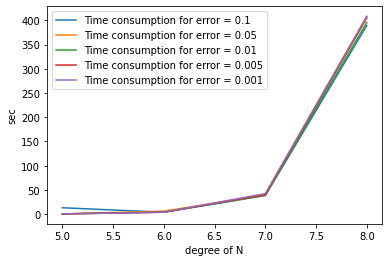

In [ ]:
plt.plot([5, 6, 7, 8], times[0::5], label="Time consumption for error = 0.1")
plt.plot([5, 6, 7, 8], times[1::5], label="Time consumption for error = 0.05")
plt.plot([5, 6, 7, 8], times[2::5], label="Time consumption for error = 0.01")
plt.plot([5, 6, 7, 8], times[3::5], label="Time consumption for error = 0.005")
plt.plot([5, 6, 7, 8], times[4::5], label="Time consumption for error = 0.001")
plt.xlabel("degree of N")
plt.ylabel("sec")
plt.legend()
plt.show()

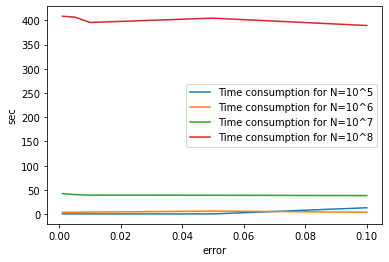

In [ ]:
plt.plot([0.1, 0.05, 0.01, 0.005, 0.001], times[0:5], label="Time consumption for N=10^5")
plt.plot([0.1, 0.05, 0.01, 0.005, 0.001], times[5:10], label="Time consumption for N=10^6")
plt.plot([0.1, 0.05, 0.01, 0.005, 0.001], times[10:15], label="Time consumption for N=10^7")
plt.plot([0.1, 0.05, 0.01, 0.005, 0.001], times[15:20], label="Time consumption for N=10^8")
plt.xlabel("error")
plt.ylabel("sec")
plt.legend()
plt.show()

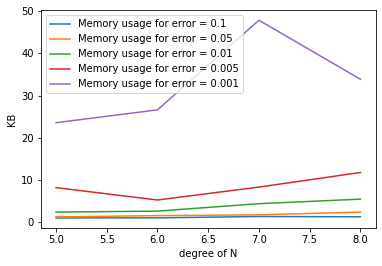

In [ ]:
plt.plot([5, 6, 7, 8], mems[0::5], label="Memory usage for error = 0.1")
plt.plot([5, 6, 7, 8], mems[1::5], label="Memory usage for error = 0.05")
plt.plot([5, 6, 7, 8], mems[2::5], label="Memory usage for error = 0.01")
plt.plot([5, 6, 7, 8], mems[3::5], label="Memory usage for error = 0.005")
plt.plot([5, 6, 7, 8], mems[4::5], label="Memory usage for error = 0.001")
plt.xlabel("degree of N")
plt.ylabel("KB")
plt.legend()
plt.show()

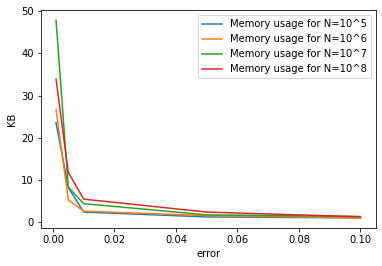

In [ ]:
plt.plot([0.1, 0.05, 0.01, 0.005, 0.001], mems[0:5], label="Memory usage for N=10^5")
plt.plot([0.1, 0.05, 0.01, 0.005, 0.001], mems[5:10], label="Memory usage for N=10^6")
plt.plot([0.1, 0.05, 0.01, 0.005, 0.001], mems[10:15], label="Memory usage for N=10^7")
plt.plot([0.1, 0.05, 0.01, 0.005, 0.001], mems[15:20], label="Memory usage for N=10^8")
plt.xlabel("error")
plt.ylabel("KB")
plt.legend()
plt.show()

In [ ]:
times

[13.09833812713623,
 0.396068811416626,
 0.3794064521789551,
 0.40666985511779785,
 0.38063478469848633,
 3.842325448989868,
 6.1911962032318115,
 4.118206262588501,
 3.8941709995269775,
 3.9458625316619873,
 38.195714473724365,
 38.92148184776306,
 39.24552059173584,
 40.31395673751831,
 42.30532264709473,
 389.3643319606781,
 404.5632472038269,
 395.65326952934265,
 406.6853737831116,
 408.49933385849]

In [ ]:
mems

[1.03125,
 1.2734375,
 2.4140625,
 8.203125,
 23.578125,
 1.046875,
 1.5703125,
 2.640625,
 5.2734375,
 26.625,
 1.3671875,
 1.7578125,
 4.40625,
 8.3359375,
 47.84375,
 1.296875,
 2.4140625,
 5.4765625,
 11.7890625,
 33.8671875]

### Conclusion
The graphs show how time and memory depend on the $N$ - length of the dataset and $e$ - error. Time consumption depends only on the length of the dataset. Memory usage depends on both the length and the error as the values of $b$ and $k$ are different for different $(N, e)$ pairs. 

To calculate memory usage, I calculated size of all lists that I used during my implementation (not only buffers), so it is bigger than the ones that presented in the paper. I used:
1. $bk$ for buffers
2. $b$ for levels list
3. $b$ for weights
4. $b$ for cursors (needed during collapse operation and to not create every time new list, just allocating memory in advance)
5. $k$ for collapsed buffer (same as cursors, it needed every collapse operation)

In total, $bk+b+b+b+k = bk + 3b + k$ memory is needed.

